# **Задание**

### Классификация по тональности
В этом домашнем задании вам предстоит классифицировать по тональности отзывы на банки с сайта banki.ru.

Данные содержат непосредственно тексты отзывов, некоторую дополнительную информацию, а также оценку по шкале от 1 до 5.

Тексты хранятся в json-ах в массиве responses.

Посмотрим на примере отзыва: возьмите для удобства ноутбук, размещенный в папке репозитория.

In [ ]:
import json
from collections import Counter
from string import punctuation
import os

import bz2
import regex
import re
from tqdm import tqdm
from scipy import sparse
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import TfidfVectorizer

import pandas as pd
import numpy as np
import nltk
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# %pylab inline

import warnings
warnings.filterwarnings('ignore')
tqdm.pandas()

!pip install pymorphy2

In [ ]:
responses = []
with bz2.BZ2File('banki_responses.json.bz2', 'r') as thefile:
    for row in tqdm(thefile):
        resp = json.loads(row)
        if not resp['rating_not_checked'] and (len(resp['text'].split()) > 0):
            responses.append(resp)
len(responses)

201030it [00:43, 4582.15it/s]


153499

In [ ]:
responses[99]

{'city': 'г. Саратов',
 'rating_not_checked': False,
 'title': 'Карта ко вкладу',
 'num_comments': 0,
 'bank_license': 'лицензия № 880',
 'author': 'ronnichka',
 'bank_name': 'Югра',
 'datetime': '2015-06-03 20:56:57',
 'text': 'Здравствуйте! Хотела написать, что мне месяц не выдают карту ко вкладу, ссылаясь на "нам же их из Самары везут" (на секундочку 5 часов езды от нашего города). Но! Прочитала, что людям 3,5 месяцев не выдают карту, и поняла, что у меня все хорошо, пока что. И подарок мне дали, и кулер в отделении есть. Так что я, конечно, готова ждать. Правда хотелось бы не очень долго.',
 'rating_grade': 3}

In [ ]:
df = pd.DataFrame(responses) #.sample(50000)
df['datetime'] = pd.to_datetime(df['datetime'])
df

,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade
0,г. Москва,False,Жалоба,0,лицензия № 2562,uhnov1,Бинбанк,2015-06-08 12:50:54,Добрый день! Я не являюсь клиентом банка и пор...,NaN
1,г. Новосибирск,False,Не могу пользоваться услугой Сбербанк он-лайн,0,лицензия № 1481,Foryou,Сбербанк России,2015-06-08 11:09:57,Доброго дня! Являюсь держателем зарплатной кар...,NaN
2,г. Москва,False,Двойное списание за один товар.,1,лицензия № 2562,Vladimir84,Бинбанк,2015-06-05 20:14:28,Здравствуйте! Дублирую свое заявление от 03.0...,NaN
3,г. Ставрополь,False,Меняют проценты комиссии не предупредив и не ...,2,лицензия № 1481,643609,Сбербанк России,2015-06-05 13:51:01,Добрый день!! Я открыл расчетный счет в СберБа...,NaN
4,г. Челябинск,False,Верните денежные средства за страховку,1,лицензия № 2766,anfisa-2003,ОТП Банк,2015-06-05 10:58:12,"04.03.2015 г. взяла кредит в вашем банке, заяв...",NaN
...,...,...,...,...,...,...,...,...,...,...
153494,None,False,Не все так страшно,0,лицензия № 2557,Вера,Ситибанк,2005-05-18 14:38:00,"Слишком большой банк, не всегда учитывает нашу...",5.0
153495,None,False,А вы договор читали?,0,лицензия № 2557,Kirill,Ситибанк,2005-04-14 15:25:00,"Вы сами виноваты в своих проблемах, кроме пред...",3.0
153496,None,False,"Филиал банка ""ОВК"" в г. Иваново",1,лицензия № 2272,AlexU-post,Росбанк,2005-04-08 14:07:00,Уважаемое руководство банка «ОВК»! Я проживаю ...,1.0
153497,None,False,В Альфа-Банк больше обращаться не буду.,0,лицензия № 1326,Ирина,Альфа-Банк,2005-04-14 15:16:00,Пробовала 10.04.05 оформить товар в кредит в А...,1.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153499 entries, 0 to 153498
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   city                138325 non-null  object        
 1   rating_not_checked  153499 non-null  bool          
 2   title               153499 non-null  object        
 3   num_comments        153499 non-null  int64         
 4   bank_license        153498 non-null  object        
 5   author              153479 non-null  object        
 6   bank_name           153499 non-null  object        
 7   datetime            153499 non-null  datetime64[ns]
 8   text                153499 non-null  object        
 9   rating_grade        88658 non-null   float64       
dtypes: bool(1), datetime64[ns](1), float64(1), int64(1), object(6)
memory usage: 10.7+ MB


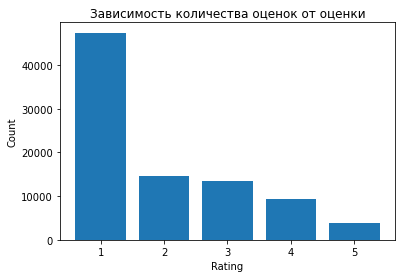

In [ ]:
plt.bar(range(1,6),df['rating_grade'].value_counts())
plt.xlabel('Rating')
plt.ylabel('Count')

plt.title('Зависимость количества оценок от оценки');

# Часть 1. Анализ текстов

## 1. Посчитайте количество отзывов в разных городах и на разные банки

In [ ]:
df['city'].value_counts()

г. Москва                               55354
г. Санкт-Петербург                      14342
г. Екатеринбург                          2337
г. Новосибирск                           2300
г. Нижний Новгород                       1976
                                        ...  
г. г.Калуга                                 1
г. ВЕЛИКИЕ ЛУКИ                             1
г. всеволожск                               1
г. сейчас                                   1
г. Краснодарский край, ст.Павловская        1
Name: city, Length: 5823, dtype: int64

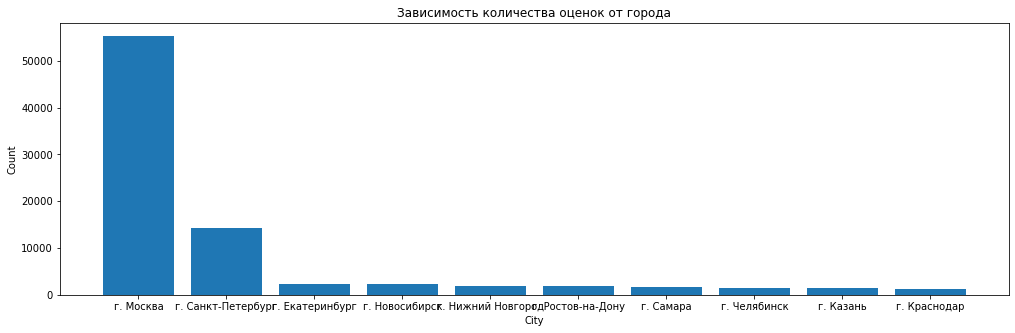

In [ ]:
plt.figure(figsize=(17,5))
plt.bar(df['city'].value_counts().index[:10],df['city'].value_counts()[:10])
plt.xlabel('City')
plt.ylabel('Count')

plt.title('Зависимость количества оценок от города');

In [ ]:
df['bank_name'].value_counts()

Сбербанк России     26327
Альфа-Банк          10224
ВТБ 24               8185
Русский Стандарт     7943
Хоум Кредит Банк     7549
                    ...  
Сиббизнесбанк           1
Донбанк                 1
Потенциал               1
Ури Банк                1
БайкалИнвестБанк        1
Name: bank_name, Length: 670, dtype: int64

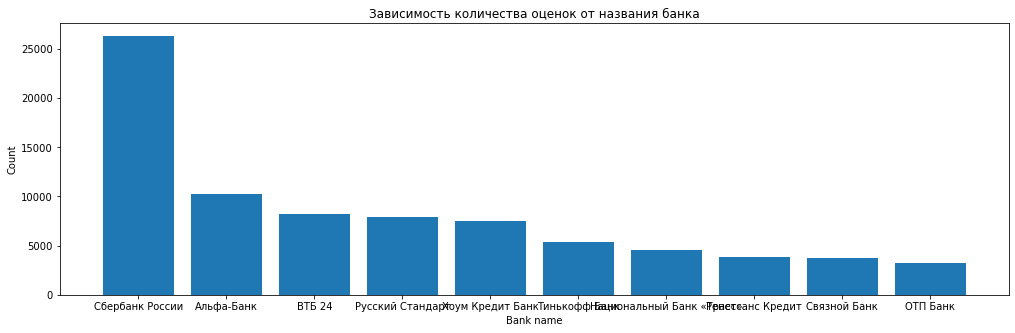

In [ ]:
plt.figure(figsize=(17,5))
plt.bar(df['bank_name'].value_counts().index[:10], df['bank_name'].value_counts()[:10])
plt.xlabel('Bank name')
plt.ylabel('Count')

plt.title('Зависимость количества оценок от названия банка');

In [ ]:
df.groupby(by=df['bank_name']).rating_grade.value_counts()

bank_name      rating_grade
2Т Банк        1.0             203
               2.0              78
               3.0              51
               5.0              26
               4.0              23
                              ... 
Яндекс.Деньги  2.0              15
               3.0               2
Ярославич      5.0               3
Ярсоцбанк      5.0               3
               3.0               1
Name: rating_grade, Length: 1851, dtype: int64

In [ ]:
df.groupby(by=['bank_name','city']).rating_grade.value_counts()

bank_name      city                   rating_grade
2Т Банк        г. Moscow              3.0             1
               г. Mscow               5.0             1
               г. Белгород (Москва)   1.0             1
               г. Бугульма            1.0             1
               г. Волгодонск          1.0             1
                                                     ..
Яндекс.Деньги  г. Челябинск           1.0             2
               г. Череповец           1.0             1
               г. Ярославль (Москва)  1.0             1
Ярославич      г. Москва              5.0             2
               г. Ярославль           5.0             1
Name: rating_grade, Length: 18421, dtype: int64

## 2. Постройте гистограмы длин слов в символах и в словах

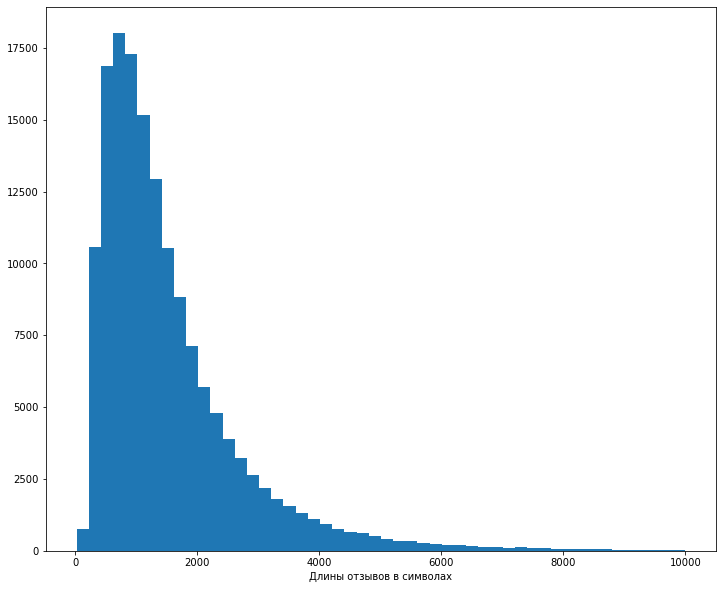

In [ ]:
len_c = df['text'].apply(len)
len_c[len_c<10000].plot(kind='hist',bins=50,figsize=(12,10))
plt.xlabel('Длины отзывов в символах')
plt.ylabel('')
plt.show()

## 3. Найдите 10 самых частых:
  - слов
  - слов без стоп-слов
  - лемм
  - существительных

In [ ]:
# Добавляем столбцы с токенами
regex = re.compile("[А-Яа-я]+")

def words_only(text, regex=regex):
    try:
        return " ".join(regex.findall(text))
    except:
        return ""

In [ ]:
%%time
df['tokens'] =  df.text.str.lower().apply(words_only)
df

Wall time: 9.76 s


,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade,tokens
0,г. Москва,False,Жалоба,0,лицензия № 2562,uhnov1,Бинбанк,2015-06-08 12:50:54,Добрый день! Я не являюсь клиентом банка и пор...,NaN,добрый день я не являюсь клиентом банка и пору...
1,г. Новосибирск,False,Не могу пользоваться услугой Сбербанк он-лайн,0,лицензия № 1481,Foryou,Сбербанк России,2015-06-08 11:09:57,Доброго дня! Являюсь держателем зарплатной кар...,NaN,доброго дня являюсь держателем зарплатной карт...
2,г. Москва,False,Двойное списание за один товар.,1,лицензия № 2562,Vladimir84,Бинбанк,2015-06-05 20:14:28,Здравствуйте! Дублирую свое заявление от 03.0...,NaN,здравствуйте дублирую свое заявление от в до м...
3,г. Ставрополь,False,Меняют проценты комиссии не предупредив и не ...,2,лицензия № 1481,643609,Сбербанк России,2015-06-05 13:51:01,Добрый день!! Я открыл расчетный счет в СберБа...,NaN,добрый день я открыл расчетный счет в сбербанк...
4,г. Челябинск,False,Верните денежные средства за страховку,1,лицензия № 2766,anfisa-2003,ОТП Банк,2015-06-05 10:58:12,"04.03.2015 г. взяла кредит в вашем банке, заяв...",NaN,г взяла кредит в вашем банке заявленная мною с...
...,...,...,...,...,...,...,...,...,...,...,...
153494,None,False,Не все так страшно,0,лицензия № 2557,Вера,Ситибанк,2005-05-18 14:38:00,"Слишком большой банк, не всегда учитывает нашу...",5.0,слишком большой банк не всегда учитывает нашу ...
153495,None,False,А вы договор читали?,0,лицензия № 2557,Kirill,Ситибанк,2005-04-14 15:25:00,"Вы сами виноваты в своих проблемах, кроме пред...",3.0,вы сами виноваты в своих проблемах кроме предп...
153496,None,False,"Филиал банка ""ОВК"" в г. Иваново",1,лицензия № 2272,AlexU-post,Росбанк,2005-04-08 14:07:00,Уважаемое руководство банка «ОВК»! Я проживаю ...,1.0,уважаемое руководство банка овк я проживаю в г...
153497,None,False,В Альфа-Банк больше обращаться не буду.,0,лицензия № 1326,Ирина,Альфа-Банк,2005-04-14 15:16:00,Пробовала 10.04.05 оформить товар в кредит в А...,1.0,пробовала оформить товар в кредит в альфа банк...


Частотные слова

In [ ]:
cnt = Counter()
n_types = []
n_tokens = []
tokens = []

for index, row in tqdm(df.iterrows(), total = len(df)):
    tokens = row['tokens'].split()
    cnt.update(tokens)
    n_types.append(len(cnt))
    n_tokens.append(sum(cnt.values()))
    
for i in cnt.most_common(10):
    print(i)

100%|██████████| 153499/153499 [03:39<00:00, 698.62it/s]

('в', 1330550)
('и', 1058997)
('не', 855335)
('на', 707935)
('что', 640057)
('я', 577500)
('с', 464037)
('по', 372769)
('мне', 320958)
('банка', 275906)


Самые частые слова без стоп-слов

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\myaut\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
mystopwords = stopwords.words('russian') + [
    'это', 'наш' , 'тыс', 'млн', 'млрд', 'также',  'т', 'д',
    'который','прошлый','сей', 'свой', 'наш', 'мочь', 'такой'
]
def remove_stopwords(text, mystopwords = mystopwords):
    try:
        return " ".join([token for token in text.split() if not token in mystopwords])
    except:
        return ""

In [ ]:
%%time
df['text_tokinized_stop_worlds'] = df['tokens'].str.lower().apply(remove_stopwords)

Wall time: 41.1 s


In [ ]:
df

,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade,tokens,text_tokinized_stop_worlds
0,г. Москва,False,Жалоба,0,лицензия № 2562,uhnov1,Бинбанк,2015-06-08 12:50:54,Добрый день! Я не являюсь клиентом банка и пор...,NaN,добрый день я не являюсь клиентом банка и пору...,добрый день являюсь клиентом банка поручителем...
1,г. Новосибирск,False,Не могу пользоваться услугой Сбербанк он-лайн,0,лицензия № 1481,Foryou,Сбербанк России,2015-06-08 11:09:57,Доброго дня! Являюсь держателем зарплатной кар...,NaN,доброго дня являюсь держателем зарплатной карт...,доброго дня являюсь держателем зарплатной карт...
2,г. Москва,False,Двойное списание за один товар.,1,лицензия № 2562,Vladimir84,Бинбанк,2015-06-05 20:14:28,Здравствуйте! Дублирую свое заявление от 03.0...,NaN,здравствуйте дублирую свое заявление от в до м...,здравствуйте дублирую свое заявление можайский...
3,г. Ставрополь,False,Меняют проценты комиссии не предупредив и не ...,2,лицензия № 1481,643609,Сбербанк России,2015-06-05 13:51:01,Добрый день!! Я открыл расчетный счет в СберБа...,NaN,добрый день я открыл расчетный счет в сбербанк...,добрый день открыл расчетный счет сбербанке юр...
4,г. Челябинск,False,Верните денежные средства за страховку,1,лицензия № 2766,anfisa-2003,ОТП Банк,2015-06-05 10:58:12,"04.03.2015 г. взяла кредит в вашем банке, заяв...",NaN,г взяла кредит в вашем банке заявленная мною с...,г взяла кредит вашем банке заявленная мною сум...
...,...,...,...,...,...,...,...,...,...,...,...,...
153494,None,False,Не все так страшно,0,лицензия № 2557,Вера,Ситибанк,2005-05-18 14:38:00,"Слишком большой банк, не всегда учитывает нашу...",5.0,слишком большой банк не всегда учитывает нашу ...,слишком большой банк учитывает нашу специфику ...
153495,None,False,А вы договор читали?,0,лицензия № 2557,Kirill,Ситибанк,2005-04-14 15:25:00,"Вы сами виноваты в своих проблемах, кроме пред...",3.0,вы сами виноваты в своих проблемах кроме предп...,сами виноваты своих проблемах кроме предпослед...
153496,None,False,"Филиал банка ""ОВК"" в г. Иваново",1,лицензия № 2272,AlexU-post,Росбанк,2005-04-08 14:07:00,Уважаемое руководство банка «ОВК»! Я проживаю ...,1.0,уважаемое руководство банка овк я проживаю в г...,уважаемое руководство банка овк проживаю г ива...
153497,None,False,В Альфа-Банк больше обращаться не буду.,0,лицензия № 1326,Ирина,Альфа-Банк,2005-04-14 15:16:00,Пробовала 10.04.05 оформить товар в кредит в А...,1.0,пробовала оформить товар в кредит в альфа банк...,пробовала оформить товар кредит альфа банке ко...


In [ ]:
cnt = Counter()
n_types = []
n_tokens = []
tokens = []
tokens_all = []

for index, row in tqdm(df.iterrows(), total = len(df)):
    tokens = row['text_tokinized_stop_worlds'].split()
    tokens_all.append(tokens)
    cnt.update(tokens)
    n_types.append(len(cnt))
    n_tokens.append(sum(cnt.values()))
    
for i in cnt.most_common(10):
    print(i)

100%|██████████| 153499/153499 [03:34<00:00, 717.07it/s]

('банка', 275906)
('банк', 215426)
('деньги', 131201)
('карту', 105829)
('карты', 101821)
('кредит', 81136)
('день', 76552)
('банке', 72169)
('заявление', 70423)
('очень', 66824)


Леммы

In [ ]:
from pymorphy2 import MorphAnalyzer
m = MorphAnalyzer()

In [ ]:
def remove_stopwords(text, mystopwords = mystoplemmas):
    try:
        return " ".join([token for token in text.split() if not token in mystoplemmas])
    except:
        return ""

In [ ]:
mystoplemmas = stopwords.words('russian') + ['который','прошлый','сей','свой','наш','мочь','г','в','и','не','на','что','с','по','т', 'д','для','я']

def lemmatize(text):
    try:
        return " ".join([m.parse(w)[0].normal_form for w in text.split()])  
    except:
        return " "


In [ ]:
%%time
df['lemma'] = df['tokens'].apply(lemmatize)

Wall time: 1h 42min 40s


In [ ]:
df

,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade,tokens,text_tokinized_stop_worlds,lemma
0,г. Москва,False,Жалоба,0,лицензия № 2562,uhnov1,Бинбанк,2015-06-08 12:50:54,Добрый день! Я не являюсь клиентом банка и пор...,NaN,добрый день я не являюсь клиентом банка и пору...,добрый день являюсь клиентом банка поручителем...,добрый день я не являться клиент банк и поручи...
1,г. Новосибирск,False,Не могу пользоваться услугой Сбербанк он-лайн,0,лицензия № 1481,Foryou,Сбербанк России,2015-06-08 11:09:57,Доброго дня! Являюсь держателем зарплатной кар...,NaN,доброго дня являюсь держателем зарплатной карт...,доброго дня являюсь держателем зарплатной карт...,добрый день являться держатель зарплатный карт...
2,г. Москва,False,Двойное списание за один товар.,1,лицензия № 2562,Vladimir84,Бинбанк,2015-06-05 20:14:28,Здравствуйте! Дублирую свое заявление от 03.0...,NaN,здравствуйте дублирую свое заявление от в до м...,здравствуйте дублирую свое заявление можайский...,здравствуйте дублировать свой заявление от в д...
3,г. Ставрополь,False,Меняют проценты комиссии не предупредив и не ...,2,лицензия № 1481,643609,Сбербанк России,2015-06-05 13:51:01,Добрый день!! Я открыл расчетный счет в СберБа...,NaN,добрый день я открыл расчетный счет в сбербанк...,добрый день открыл расчетный счет сбербанке юр...,добрый день я открыть расчётный счёт в сбербан...
4,г. Челябинск,False,Верните денежные средства за страховку,1,лицензия № 2766,anfisa-2003,ОТП Банк,2015-06-05 10:58:12,"04.03.2015 г. взяла кредит в вашем банке, заяв...",NaN,г взяла кредит в вашем банке заявленная мною с...,г взяла кредит вашем банке заявленная мною сум...,г взять кредит в ваш банк заявить я сумма быть...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
153494,None,False,Не все так страшно,0,лицензия № 2557,Вера,Ситибанк,2005-05-18 14:38:00,"Слишком большой банк, не всегда учитывает нашу...",5.0,слишком большой банк не всегда учитывает нашу ...,слишком большой банк учитывает нашу специфику ...,слишком большой банк не всегда учитывать наш с...
153495,None,False,А вы договор читали?,0,лицензия № 2557,Kirill,Ситибанк,2005-04-14 15:25:00,"Вы сами виноваты в своих проблемах, кроме пред...",3.0,вы сами виноваты в своих проблемах кроме предп...,сами виноваты своих проблемах кроме предпослед...,вы сам виноватый в свой проблема кроме предпос...
153496,None,False,"Филиал банка ""ОВК"" в г. Иваново",1,лицензия № 2272,AlexU-post,Росбанк,2005-04-08 14:07:00,Уважаемое руководство банка «ОВК»! Я проживаю ...,1.0,уважаемое руководство банка овк я проживаю в г...,уважаемое руководство банка овк проживаю г ива...,уважаемый руководство банк овк я проживать в г...
153497,None,False,В Альфа-Банк больше обращаться не буду.,0,лицензия № 1326,Ирина,Альфа-Банк,2005-04-14 15:16:00,Пробовала 10.04.05 оформить товар в кредит в А...,1.0,пробовала оформить товар в кредит в альфа банк...,пробовала оформить товар кредит альфа банке ко...,пробовать оформить товар в кредит в альфа банк...


In [ ]:
cnt = Counter()
n_types = []
n_tokens = []
tokens = []
tokens_all=[]

for index, row in tqdm(df.iterrows(), total = len(df)):
    tokens = row['lemma'].split()
    cnt.update(tokens)
    n_types.append(len(cnt))
    tokens_all+=tokens
    n_tokens.append(sum(cnt.values()))
    
for i in cnt.most_common(10):
    print(i)



#all_lemmas = []
#for i in tqdm(range(len(tokens_all))):
   # tokens = tokens_all.split()
    
   # lemma.append(m.lemmatize(index))
    
   # all_lemmas.append(''.join(lemmas))
   # cnt.update(lemmas)
   # n_types.append(len(cnt))
   # n_tokens.append(sum(cnt.values()))
#for i in cnt.most_common(10):
   # print(i)

100%|██████████| 153499/153499 [01:26<00:00, 1766.43it/s]

('в', 1355398)
('я', 1122833)
('и', 1058997)
('не', 855335)
('на', 707935)
('банк', 668563)
('что', 662722)
('с', 524541)
('быть', 454282)
('по', 372769)


Существительные

In [ ]:
def to_nouns(text, mystem=m):
    try:
        return " ".join([noun for noun in text.split() if m.parse(noun)[0].tag.POS =='NOUN'])
    except:
        return ""

to_nouns(df['tokens'].iloc[1])

'дня держателем карты сбербанком россии году фамилию банк документы копию паспорта свидетельства браке карту фамилию мужа токарева мария александровна секлетина необходимость услугу сбербанк странице карты специалистом отделения сбербанка базе банка фамилией секлетина сканы документов контакты звонка ч время ситуацию базе секлетиной карту раз фамилию токарева связи истечением срока обслуживания документы копию паспорта свидетельства браке результат ноль ситуации уважением токарева мария александровна'

In [ ]:
%%time
df['nouns'] = df['tokens'].apply(to_nouns)

Wall time: 1h 45min 12s


In [ ]:
cnt_noun = Counter()
n_types_noun = []
n_tokens_noun = []
tokens_noun = []
tokens_all_noun=[]

for index, row in tqdm(df.iterrows(), total = len(df)):
    tokens = row['nouns'].split()
    cnt_noun.update(tokens)
    n_types_noun.append(len(cnt))
    tokens_all_noun+=tokens
    n_tokens_noun.append(sum(cnt.values()))
    
for i in cnt_noun.most_common(10):
    print(i) 

100%|██████████| 153499/153499 [01:59<00:00, 1281.81it/s]

('банка', 275906)
('банк', 215426)
('деньги', 131201)
('карту', 105829)
('карты', 101821)
('кредит', 81136)
('день', 76552)
('раз', 75943)
('банке', 72169)
('заявление', 70423)


## 4. Постройте кривые Ципфа и Хипса

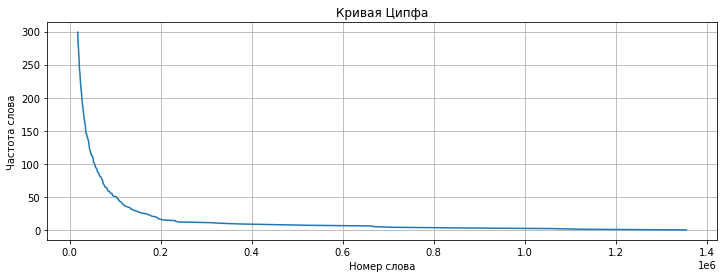

In [ ]:
#Кривая Ципфа
freqs = list(cnt.values())
freqs = sorted(freqs, reverse = True)

fig, ax = plt.subplots(figsize=(12,4))
ax.plot(freqs[:300], range(300))
plt.xlabel('Номер слова')
plt.ylabel('Частота слова')
plt.title('Кривая Ципфа')
plt.grid()

plt.show()

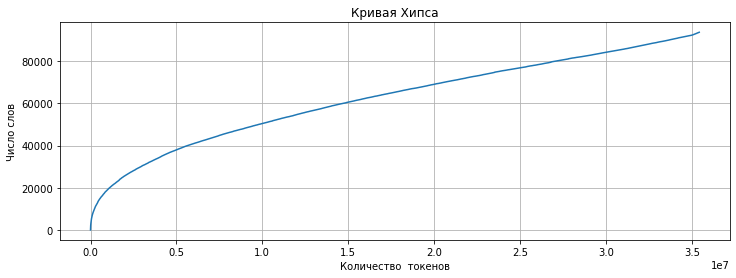

In [ ]:
#кривая Хипса
fig, ax = plt.subplots(figsize=(12,4))
ax.plot(n_tokens,n_types)
plt.xlabel('Количество  токенов')
plt.ylabel('Число слов')
plt.title('Кривая Хипса')
plt.grid()

plt.show()

## Ответьте на следующие вопросы:
  - какое слово встречается чаще, "сотрудник" или "клиент"?
  - сколько раз встречается слова "мошенничество" и "доверие"?

In [ ]:
from nltk import FreqDist
Freq_Dist = FreqDist(tokens_all)

In [ ]:
print('сотрудник:', Freq_Dist['сотрудник'])
print('клиент:', Freq_Dist['клиент'])

сотрудник: 134168
клиент: 136892


In [ ]:
print('мошенничество:', Freq_Dist['мошенничество'])
print('доверие:', Freq_Dist['доверие'])

мошенничество: 3244
доверие: 2108


### В поле "rating_grade" записана оценка отзыва по шкале от 1 до 5. Используйте меру $tf-idf$, для того, чтобы найти ключевые слова и биграмы для положительных отзывов (с оценкой 5) и отрицательных отзывов (с оценкой 1)

In [ ]:
df['rating_grade'].value_counts()

1.0    47387
5.0    14713
2.0    13509
3.0     9261
4.0     3788
Name: rating_grade, dtype: int64

In [ ]:
num=10000

df_sample = df[(df.rating_grade==1)].sample(n=num).copy()
df_sample = df_sample.append(df[(df.rating_grade==5)].sample(n=num,replace=True))

df_sample.rating_grade.value_counts()

1.0    10000
5.0    10000
Name: rating_grade, dtype: int64

Ключевые слова

In [ ]:
tokens_by_topic = []

for rating in df_sample.rating_grade.unique():
    tokens=[]
    sample=df_sample[df_sample['rating_grade']==rating]
    
    for i in range(len(sample)):
        tokens += sample.lemma.iloc[i].split()
        
    tokens_by_topic.append(tokens)

In [ ]:
df_sample.head(3)

,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade,tokens,text_tokinized_stop_worlds,lemma,nouns
79563,г. Пермь,False,Ужасная работа филиала в Перми,2,лицензия № 3279,doklyubov,Национальный Банк «Траст»,2013-07-10 15:57:00,В марте ходила с мамой открывать счет в этом б...,1.0,в марте ходила с мамой открывать счет в этом б...,марте ходила мамой открывать счет банке потрат...,в март ходить с мама открывать счёт в это банк...,марте мамой счет банке часов ожидание оформлен...
81924,г. Рязань,False,Отказ от использования (ранее очень удобной) к...,0,лицензия № 1961,ХХХ!,Связной Банк,2013-06-07 23:58:00,"Получила карту в 2011 г. в Связном, в одном из...",1.0,получила карту в г в связном в одном из городо...,получила карту г связном одном городов вашего ...,получить карта в г в связный в один из город г...,карту г городов офиса числе деньги сумма плате...
138597,None,False,Не работает Инет-банкинг,4,лицензия № 2766,Krodt,ОТП Банк,2009-06-09 09:27:00,"И опять, как и полторы недели назад, не работа...",1.0,и опять как и полторы недели назад не работает...,полторы недели назад работает интернет банкинг...,и опять как и полтора неделя назад не работать...,недели интернет банкинг дней дней труд клиента...


Униграмы

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

tfidf = TfidfVectorizer(analyzer='word', ngram_range=(1,1), min_df = 0)
tfidf_matrix =  tfidf.fit_transform([' '.join(tokens) for tokens in tokens_by_topic])
feature_names = tfidf.get_feature_names() 
tfidf_ranking_5 = []
tfidf_ranking_1 = []
dense = tfidf_matrix.todense()

text = dense[1].tolist()[0]
phrase_scores = [pair for pair in zip(range(0, len(text)), text) if pair[1] > 0]
sorted_phrase_scores = sorted(phrase_scores, key=lambda t: t[1] * -1)
phrases = []

for phrase, score in [(feature_names[word_id], score) for (word_id, score) in sorted_phrase_scores][:70]:
    tfidf_ranking_5.append(phrase)
    
text = dense[0].tolist()[0]
phrase_scores = [pair for pair in zip(range(0, len(text)), text) if pair[1] > 0]
sorted_phrase_scores = sorted(phrase_scores, key=lambda t: t[1] * -1)
phrases = []

for phrase, score in [(feature_names[word_id], score) for (word_id, score) in sorted_phrase_scores][:70]:
    tfidf_ranking_1.append(phrase)

In [ ]:
rank = pd.DataFrame({'tfidf_ranking_5': tfidf_ranking_5,'tfidf_ranking_1': tfidf_ranking_1})
rank.head(10)

,tfidf_ranking_5,tfidf_ranking_1
0,банк,не
1,не,на
2,на,что
3,что,банк
4,быть,быть
5,по,по
6,это,карта
7,карта,это
8,всё,так
9,за,мой


Убираем пересечения

In [ ]:
rank['tfidf_ranking_5_without_1']=rank.tfidf_ranking_5[~rank.tfidf_ranking_5.isin(rank.tfidf_ranking_1)]
rank['tfidf_ranking_1_without_5']=rank.tfidf_ranking_1[~rank.tfidf_ranking_1.isin(rank.tfidf_ranking_5)]

In [ ]:
rank.iloc[:,-2:].dropna()

,tfidf_ranking_5_without_1,tfidf_ranking_1_without_5
61,спасибо,телефон
64,документ,дать
66,работать,написать
68,минута,банкомат
69,интернет,платёж


Биграммы

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

tfidf = TfidfVectorizer(analyzer='word', ngram_range=(2,2), min_df = 0)
tfidf_matrix =  tfidf.fit_transform([' '.join(tokens) for tokens in tokens_by_topic])
feature_names = tfidf.get_feature_names() 
tfidf_ranking_rank_is_5 = []
tfidf_ranking_rank_is_1 = []
dense = tfidf_matrix.todense()

text = dense[1].tolist()[0]
phrase_scores = [pair for pair in zip(range(0, len(text)), text) if pair[1] > 0]
sorted_phrase_scores = sorted(phrase_scores, key=lambda t: t[1] * -1)
phrases = []

for phrase, score in [(feature_names[word_id], score) for (word_id, score) in sorted_phrase_scores][:70]:
    tfidf_ranking_rank_is_5.append(phrase)
    
text = dense[0].tolist()[0]
phrase_scores = [pair for pair in zip(range(0, len(text)), text) if pair[1] > 0]
sorted_phrase_scores = sorted(phrase_scores, key=lambda t: t[1] * -1)
phrases = []

for phrase, score in [(feature_names[word_id], score) for (word_id, score) in sorted_phrase_scores][:70]:
    tfidf_ranking_rank_is_1.append(phrase) 

In [ ]:
rankings = pd.DataFrame({'tfidf_ranking_rank_is_5': tfidf_ranking_rank_is_5,'tfidf_ranking_rank_is_1': tfidf_ranking_rank_is_1})
rankings.head(10)

,tfidf_ranking_rank_is_5,tfidf_ranking_rank_is_1
0,не быть,сказать что
1,сказать что,не мочь
2,интернет банк,не быть
3,другой банк,тот что
4,тот что,сотрудник банк
5,то что,на мой
6,это банк,банк не
7,кредитный карта,так как
8,сотрудник банк,по телефон
9,так как,кредитный карта


In [ ]:
rankings['tfidf_ranking_rank_is_5_without_1']=rankings.tfidf_ranking_rank_is_5[~rankings.tfidf_ranking_rank_is_5.isin(rankings.tfidf_ranking_rank_is_1)]
rankings['tfidf_ranking_rank_is_1_without_5']=rankings.tfidf_ranking_rank_is_1[~rankings.tfidf_ranking_rank_is_1.isin(rankings.tfidf_ranking_rank_is_5)]

In [ ]:
rankings.iloc[:,-2:].dropna()

,tfidf_ranking_rank_is_5_without_1,tfidf_ranking_rank_is_1_without_5
25,на всё,так не
32,офис на,горячий линия
36,от администратор,не смочь
38,банк который,ответить что
40,хотеться бы,должный быть
42,так же,колл центр
48,банк за,ваш банк
49,дебетовый карта,карта не
52,этот банк,что она
54,по мой,сей пора


# Часть 2. Тематическое моделирование

## 1. Постройте несколько тематических моделей коллекции документов с разным числом тем. Приведите примеры понятных (интерпретируемых) тем.
## 2. Найдите темы, в которых упомянуты конкретные банки (Сбербанк, ВТБ, другой банк). Можете ли вы их прокомментировать / объяснить?
 Эта часть задания может быть сделана с использованием gensim.

In [ ]:
!pip install --upgrade gensim

In [ ]:
import gensim.corpora as corpora
from gensim.models import ldamodel

In [ ]:
text = [df['lemma'].iloc[i].split() for i in range(len(df))]
dictionary = corpora.Dictionary(text)
corpus = [dictionary.doc2bow(text) for text in text]

In [ ]:
lda_30 = ldamodel.LdaModel(corpus = corpus,
                        id2word = dictionary,
                        num_topics = 30,
                        iterations = 20,
                        passes = 5,
                        per_word_topics = True)
lda_30.show_topics(5)

[(20,
  '0.056*"документ" + 0.042*"в" + 0.029*"на" + 0.024*"кредит" + 0.024*"и" + 0.021*"справка" + 0.018*"банк" + 0.017*"быть" + 0.013*"не" + 0.013*"квартира"'),
 (2,
  '0.046*"в" + 0.037*"я" + 0.028*"платёж" + 0.028*"сумма" + 0.026*"и" + 0.025*"кредит" + 0.024*"банк" + 0.021*"по" + 0.020*"задолженность" + 0.019*"быть"'),
 (19,
  '0.056*"служба" + 0.046*"письмо" + 0.044*"поддержка" + 0.036*"почта" + 0.028*"ответ" + 0.025*"на" + 0.023*"в" + 0.018*"по" + 0.018*"вы" + 0.018*"электронный"'),
 (4,
  '0.121*"я" + 0.053*"и" + 0.052*"что" + 0.033*"не" + 0.023*"в" + 0.021*"быть" + 0.018*"это" + 0.017*"то" + 0.015*"а" + 0.015*"всё"'),
 (10,
  '0.480*"мы" + 0.080*"наш" + 0.042*"жена" + 0.037*"муж" + 0.022*"она" + 0.020*"он" + 0.016*"супруг" + 0.015*"мама" + 0.014*"у" + 0.010*"прислать"')]

In [ ]:
lda_15 = ldamodel.LdaModel(corpus = corpus,
                        id2word = dictionary,
                        num_topics = 15,
                        iterations = 10,
                        passes = 5,
                        per_word_topics = True)
lda_15.show_topics(5)

[(2,
  '0.035*"не" + 0.035*"и" + 0.034*"банк" + 0.029*"с" + 0.028*"я" + 0.026*"в" + 0.023*"мой" + 0.020*"вы" + 0.019*"ваш" + 0.015*"на"'),
 (10,
  '0.041*"в" + 0.034*"мы" + 0.034*"на" + 0.029*"документ" + 0.028*"и" + 0.025*"кредит" + 0.018*"банк" + 0.015*"заявка" + 0.014*"быть" + 0.014*"что"'),
 (3,
  '0.042*"в" + 0.035*"банк" + 0.025*"не" + 0.023*"и" + 0.018*"это" + 0.017*"на" + 0.015*"с" + 0.015*"по" + 0.013*"что" + 0.011*"но"'),
 (1,
  '0.048*"в" + 0.045*"кредит" + 0.034*"я" + 0.030*"банк" + 0.027*"и" + 0.023*"платёж" + 0.022*"сумма" + 0.020*"не" + 0.017*"на" + 0.017*"по"'),
 (11,
  '0.186*"я" + 0.066*"что" + 0.041*"и" + 0.027*"в" + 0.027*"не" + 0.025*"она" + 0.022*"мой" + 0.021*"быть" + 0.019*"на" + 0.019*"сказать"')]

In [ ]:
lda_5 = ldamodel.LdaModel(corpus = corpus,
                        id2word = dictionary,
                        num_topics = 15,
                        iterations = 10,
                        passes = 5,
                        per_word_topics = True)
lda_5.show_topics(5)

[(11,
  '0.046*"я" + 0.036*"не" + 0.036*"и" + 0.032*"банк" + 0.028*"с" + 0.027*"в" + 0.025*"мой" + 0.020*"телефон" + 0.018*"на" + 0.016*"звонок"'),
 (10,
  '0.043*"не" + 0.040*"и" + 0.033*"что" + 0.033*"я" + 0.022*"а" + 0.022*"то" + 0.019*"вы" + 0.018*"они" + 0.017*"это" + 0.015*"у"'),
 (2,
  '0.073*"я" + 0.051*"в" + 0.050*"кредит" + 0.036*"банк" + 0.030*"и" + 0.021*"что" + 0.019*"не" + 0.018*"кредитный" + 0.016*"быть" + 0.015*"год"'),
 (5,
  '0.053*"и" + 0.032*"в" + 0.032*"мы" + 0.024*"банк" + 0.024*"с" + 0.017*"всё" + 0.016*"быть" + 0.016*"очень" + 0.015*"на" + 0.012*"сотрудник"'),
 (14,
  '0.155*"карта" + 0.029*"в" + 0.029*"я" + 0.025*"с" + 0.021*"банк" + 0.021*"и" + 0.019*"быть" + 0.019*"на" + 0.018*"не" + 0.017*"по"')]

In [ ]:
df.head(3)

,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade,tokens,text_tokinized_stop_worlds,lemma,nouns
0,г. Москва,False,Жалоба,0,лицензия № 2562,uhnov1,Бинбанк,2015-06-08 12:50:54,Добрый день! Я не являюсь клиентом банка и пор...,NaN,добрый день я не являюсь клиентом банка и пору...,добрый день являюсь клиентом банка поручителем...,добрый день я не являться клиент банк и поручи...,день клиентом банка поручителем договору лицом...
1,г. Новосибирск,False,Не могу пользоваться услугой Сбербанк он-лайн,0,лицензия № 1481,Foryou,Сбербанк России,2015-06-08 11:09:57,Доброго дня! Являюсь держателем зарплатной кар...,NaN,доброго дня являюсь держателем зарплатной карт...,доброго дня являюсь держателем зарплатной карт...,добрый день являться держатель зарплатный карт...,дня держателем карты сбербанком россии году фа...
2,г. Москва,False,Двойное списание за один товар.,1,лицензия № 2562,Vladimir84,Бинбанк,2015-06-05 20:14:28,Здравствуйте! Дублирую свое заявление от 03.0...,NaN,здравствуйте дублирую свое заявление от в до м...,здравствуйте дублирую свое заявление можайский...,здравствуйте дублировать свой заявление от в д...,заявление карте покупка интернет магазине сумм...


# Часть 3. Классификация текстов
Сформулируем для простоты задачу бинарной классификации: будем классифицировать на два класса, то есть, различать резко отрицательные отзывы (с оценкой 1) и положительные отзывы (с оценкой 5).

1. Составьте обучающее и тестовое множество: выберите из всего набора данных N1 отзывов с оценкой 1 и N2 отзывов с оценкой 5 (значение N1 и N2 – на ваше усмотрение). Используйте sklearn.model_selection.train_test_split для разделения множества отобранных документов на обучающее и тестовое.
2. Используйте любой известный вам алгоритм классификации текстов для решения задачи и получите baseline. Сравните разные варианты векторизации текста: использование только униграм, пар или троек слов или с использованием символьных $n$-грам.
3. Сравните, как изменяется качество решения задачи при использовании скрытых тем в качестве признаков:
- 1-ый вариант: $tf-idf$ преобразование (sklearn.feature_extraction.text.TfidfTransformer) и сингулярное разложение (оно же – латентый семантический анализ) (sklearn.decomposition.TruncatedSVD),
- 2-ой вариант: тематические модели LDA (sklearn.decomposition.LatentDirichletAllocation).
Используйте accuracy и F-measure для оценки качества классификации.

В ноутбуке, размещенном в папке репозитория. написан примерный Pipeline для классификации текстов.

Эта часть задания может быть сделана с использованием sklearn.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.ensemble import RandomForestClassifier

In [ ]:
X = df['lemma'].values
y = df['rating_grade'].fillna(0).values
print(X.shape, y.shape)

(153499,) (153499,)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((107449,), (46050,), (107449,), (46050,))

In [ ]:
vec = CountVectorizer(ngram_range=(1,1))
bow = vec.fit_transform(X_train) # bow -- bag of words (мешок слов)
clf = LogisticRegression(random_state=42, solver='liblinear')
clf.fit(bow, y_train)
predict_1 = clf.predict(vec.transform(X_test))
print(classification_report(predict_1, y_test))

              precision    recall  f1-score   support

         0.0       0.75      0.60      0.67     24570
         1.0       0.54      0.56      0.55     13703
         2.0       0.09      0.22      0.13      1665
         3.0       0.10      0.22      0.14      1194
         4.0       0.14      0.27      0.18       583
         5.0       0.68      0.69      0.68      4335

    accuracy                           0.57     46050
   macro avg       0.38      0.43      0.39     46050
weighted avg       0.63      0.57      0.59     46050



In [ ]:
vec = CountVectorizer(ngram_range=(2,2))
bow = vec.fit_transform(X_train) 
clf = LogisticRegression(random_state=42, solver='liblinear')
clf.fit(bow, y_train)
predict_2 = clf.predict(vec.transform(X_test))
print(classification_report(predict_2, y_test))

              precision    recall  f1-score   support

         0.0       0.74      0.59      0.66     24425
         1.0       0.56      0.53      0.54     15157
         2.0       0.06      0.20      0.09      1283
         3.0       0.06      0.22      0.09       706
         4.0       0.05      0.34      0.09       178
         5.0       0.68      0.70      0.69      4301

    accuracy                           0.56     46050
   macro avg       0.36      0.43      0.36     46050
weighted avg       0.64      0.56      0.60     46050



In [ ]:
vec = CountVectorizer(ngram_range=(3,3))
bow = vec.fit_transform(X_train)
clf = LogisticRegression(random_state=42, solver='liblinear')
clf.fit(bow, y_train)
predict_3 = clf.predict(vec.transform(X_test))
print(classification_report(predict_3, y_test))

              precision    recall  f1-score   support

         0.0       0.82      0.54      0.65     29457
         1.0       0.50      0.53      0.51     13429
         2.0       0.01      0.24      0.02       173
         3.0       0.01      0.31      0.01        45
         4.0       0.01      0.27      0.01        22
         5.0       0.47      0.70      0.56      2924

    accuracy                           0.55     46050
   macro avg       0.30      0.43      0.29     46050
weighted avg       0.70      0.55      0.60     46050



Использование униграм показал лучший результат

### 1 вариант
 
 $TF-IDF$

In [ ]:
vector = TfidfVectorizer()
transformer = TfidfTransformer()

bow = vector.fit_transform(X_train)
tfidf = transformer.fit_transform(bow)
clf = LogisticRegression(random_state=42, solver='liblinear')
clf.fit(tfidf, y_train)

predict_tfidf = clf.predict(vector.transform(X_test))
print(classification_report(predict_tfidf, y_test))

              precision    recall  f1-score   support

         0.0       0.60      0.69      0.64     16785
         1.0       0.82      0.48      0.61     24178
         2.0       0.02      0.22      0.04       415
         3.0       0.04      0.36      0.07       315
         4.0       0.11      0.38      0.17       335
         5.0       0.67      0.73      0.70      4022

    accuracy                           0.58     46050
   macro avg       0.38      0.48      0.37     46050
weighted avg       0.71      0.58      0.62     46050



 $ SVD $

In [ ]:
vectors = TfidfVectorizer().fit_transform(df['text']) # строим тф-идф матрицу документ-слово
X_reduced = TruncatedSVD(n_components=5, random_state=0).fit_transform(vectors) # оставляем n главных компонент

In [ ]:
X_train_svd, X_test_svd, y_train_svd, y_test_svd = train_test_split(X_reduced, df['rating_grade'].fillna(0).values, test_size=0.3)

In [ ]:
clf = LogisticRegression(random_state=42, solver='liblinear')
clf.fit(X_train_svd, y_train_svd)
pred = clf.predict(X_test_svd)
print(classification_report(pred, y_test_svd))

              precision    recall  f1-score   support

         0.0       0.79      0.49      0.60     31615
         1.0       0.36      0.41      0.38     12267
         2.0       0.00      0.00      0.00         0
         3.0       0.00      0.00      0.00         0
         4.0       0.00      0.00      0.00         0
         5.0       0.15      0.31      0.21      2168

    accuracy                           0.46     46050
   macro avg       0.22      0.20      0.20     46050
weighted avg       0.65      0.46      0.53     46050



TF-IDF показал лучшие значения метрики

$LDA$

In [ ]:
vector = TfidfVectorizer()
lda = LatentDirichletAllocation()

bow = vector.fit_transform(X_train)
X_lda = lda.fit_transform(bow)
clf = LogisticRegression(random_state=42, solver='liblinear')
clf.fit(X_lda, y_train)

In [ ]:
pred_lda = clf.predict(X_test_svd)
print(classification_report(pred_lda, y_test))

              precision    recall  f1-score   support

         0.0       0.68      0.42      0.52     31615
         1.0       0.26      0.31      0.28     12267
         2.0       0.00      0.00      0.00         0
         3.0       0.00      0.00      0.00         0
         4.0       0.00      0.00      0.00         0
         5.0       0.05      0.10      0.07      2168

    accuracy                           0.37     46050
   macro avg       0.17      0.14      0.14     46050
weighted avg       0.54      0.37      0.43     46050

